In [1]:
import numpy as np
import matplotlib.pyplot as plt
from boo import read_dataframe

In [2]:
%matplotlib inline

Читаем данные за 2012 год. Для этого они должны быть заранее скачены и преобразованы командами `boo.download(year)` и `boo.build(year)`. См. пример в [start.py](start.py)

In [40]:
df = read_dataframe(2012)

Year: 2012
Reading processed CSV file C:\Users\Евгений\Documents\GitHub\sandbox\data\processed-2012.csv


In [4]:
df.shape

(765813, 51)

В наборе данных 765 тыс строк (компаний) и 51 переменная. Какие это переменные?

In [81]:
df.head(3)

,ok1,ok2,ok3,org,title,region,inn,okpo,okopf,okfs,...,cf_fin,cf,cash_in_oper_total,cash_in_oper_sales,paid_to_supplier,paid_to_worker,paid_interest,paid_profit_tax,paid_other_costs,paid_fa_investment
0,65,23,1,ОТКРЫТОЕ АКЦИОНЕРНОЕ ОБЩЕСТВО,РОССИЙСКОЕ АКЦИОНЕРНОЕ ОБЩЕСТВО ПО ПРОИЗВОДСТВ...,24,2457009983,00002565,47,16,...,0,-7022,2952890,0,15215,32857,0,27105,2914527,0
1,70,20,2,ОТКРЫТОЕ АКЦИОНЕРНОЕ ОБЩЕСТВО,ВЛАДТЕКС,33,3328100636,00031029,47,16,...,0,0,0,0,0,0,0,0,0,0
2,70,20,2,Открытое акционерное общество,Корпоративные сервисные системы,31,3125008321,00104082,47,16,...,-18483,2232,243701,15694,7543,52345,0,0,72151,187551


In [5]:
df.columns

Index(['ok1', 'ok2', 'ok3', 'org', 'title', 'region', 'inn', 'okpo', 'okopf',
       'okfs', 'unit', 'of', 'ta_fix', 'ta_nonfix', 'ta', 'tp_capital',
       'tp_long', 'debt_long', 'tp_short', 'debt_short', 'tp', 'sales',
       'profit_oper', 'exp_interest', 'profit_before_tax', 'of_lag',
       'ta_fix_lag', 'ta_nonfix_lag', 'ta_lag', 'tp_capital_lag',
       'tp_long_lag', 'debt_long_lag', 'tp_short_lag', 'debt_short_lag',
       'tp_lag', 'sales_lag', 'profit_oper_lag', 'exp_interest_lag',
       'profit_before_tax_lag', 'cf_oper', 'cf_inv', 'cf_fin', 'cf',
       'cash_in_oper_total', 'cash_in_oper_sales', 'paid_to_supplier',
       'paid_to_worker', 'paid_interest', 'paid_profit_tax',
       'paid_other_costs', 'paid_fa_investment'],
      dtype='object')

'ok1', 'ok2', 'ok3', 'org', 'title', 'region', 'inn', 'okpo', 'okopf', 'okfs', 'unit' - служебные переменные, все остальные - показатели бухгалтерской отчетности. 

## Объем активов компаний
Посмотрим, как распределены компании в выборке по величине активов (валюты баланса).

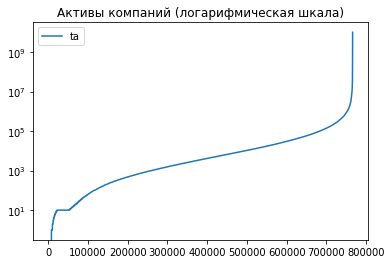

In [6]:
da0 = df[['ta', 'title', 'inn']].sort_values('ta').set_index('inn')
da0.ta.reset_index().plot(y='ta', title="Активы компаний (логарифмическая шкала)", logy=True)

Уберем компании, которые не показывают в отчетности денежный поток.

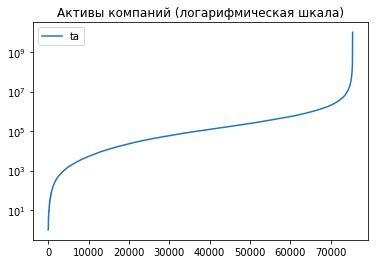

In [7]:
ix = (df.ta > 0) & (df.cf !=0)
da = df[ix][['ta', 'title', 'inn']].sort_values('ta').set_index('inn')
da.ta.reset_index().plot(y='ta', title="Активы компаний (логарифмическая шкала)", logy=True)

Условиям положительных активов и ненулевого денежного потока удовлетворяют 
всего 75 тыс. компаний, только 10% из выборки. 

In [8]:
da.shape[0]

75417

Какие же компании крупнейшие?

In [9]:
da.tail(10)[::-1][['ta','title']]

,ta,title
inn,,
7736050003,10035651782,Газпром
7708503727,4330803000,Российские железные дороги
7705630445,2661872463,РОСНЕФТЕГАЗ
7706107510,2492002228,"Нефтяная компания ""Роснефть"""
8602060555,1797065707,СУРГУТНЕФТЕГАЗ
7708004767,1188846824,"Нефтяная компания ""ЛУКОЙЛ"""
7702038150,1139903636,Московский ордена Ленина и ордена Трудового Кр...
7706664260,1136371907,Атомный энергопромышленный комплекс
4716016979,1122995318,Федеральная сетевая компания Единой энергетиче...


## Крупнейшие компании по объему выручки и продажам

Cделаем более универсальный код для построния списка крупнейших компаний.

In [152]:
import importlib
import pick
importlib.reload(pick)

<module 'pick' from 'C:\\Users\\Евгений\\Documents\\GitHub\\sandbox\\pick.py'>

In [156]:


COLUMNS_1 = ['title', 'ok1', 'region', 'inn']
COLUMNS_NUMERICAL = ['ta', 'sales', 'cf', 'cf_oper']

def rename(df, rename_dict=pick.SHORT_NAMES_BY_INN):
    ix = df.index.isin(list(rename_dict.keys()))
    df.loc[ix,['title']] = df.loc[ix].index.map(lambda inn: rename_dict[inn])
    return df

def report(df, divide_by, sort_key):
    x = df[COLUMNS_1+COLUMNS_NUMERICAL].set_index('inn')
    x = pick.dequote(pick.operational(x)) 
    x = rename(x)
    x.loc[:,COLUMNS_NUMERICAL] = x.loc[:,COLUMNS_NUMERICAL].divide(divide_by).round(1)
    return x.sort_values(sort_key, ascending=False)

af = report(df, divide_by=10**6, sort_key='ta')
af.head(30)

,title,ok1,region,ta,sales,cf,cf_oper
inn,,,,,,,
7736050003,Газпром,51,77,10035.7,3659.2,-60.7,917.3
7708503727,Российские железные дороги,60,77,4330.8,1366.0,-67.2,101.0
7705630445,РОСНЕФТЕГАЗ,74,77,2661.9,83.3,5.4,85.9
7706107510,Роснефть,23,77,2492.0,2595.7,135.8,301.5
8602060555,СУРГУТНЕФТЕГАЗ,11,86,1797.1,815.6,21.0,145.3
7708004767,ЛУКОЙЛ,74,77,1188.8,39.9,-11.1,-23.8
7702038150,Московский метрополитен,60,77,1139.9,68.4,32.3,4.4
7706664260,Атомэнергопром,72,77,1136.4,1.3,-8.5,-16.7
4716016979,ФСК ЕЭС,40,47,1123.0,138.8,0.3,68.9


In [154]:
_sf = report(df, divide_by=10**6, sort_key='sales')
sf = _sf[~pick.is_financial(_sf)]
sf.head(30)

,title,ok1,region,ta,sales,cf,cf_oper
inn,,,,,,,
7736050003,Газпром,51,77,10035.7,3659.2,-60.7,917.3
7706107510,Роснефть,23,77,2492.0,2595.7,135.8,301.5
7708503727,Российские железные дороги,60,77,4330.8,1366.0,-67.2,101.0
7225004092,ТНК-ВР Холдинг,51,72,693.5,1084.4,32.3,238.4
5504036333,Газпром нефть,51,55,754.7,905.5,46.6,60.8
5003021311,Газпром межрегионгаз,51,50,601.2,828.0,6.1,14.9
8602060555,СУРГУТНЕФТЕГАЗ,11,86,1797.1,815.6,21.0,145.3
7706061801,Транснефть,60,77,908.8,687.1,-55.4,-11.7
8608048498,ЛУКОЙЛ-Западная Сибирь,11,86,508.6,645.7,0.0,148.2


- РН-Трейдинг - это [торговое подразделение Роснефти](https://regnum.ru/news/1555228.html)
- ТАНДЕР - это Магнит
- Нужно построить список без дочек Газпрома

In [159]:
importlib.reload(pick)
pick.by_title(sf, "газпром")

,title,ok1,region,ta,sales,cf,cf_oper
inn,,,,,,,
7736050003,Газпром,51,77,10035.7,3659.2,-60.7,917.3
5504036333,Газпром нефть,51,55,754.7,905.5,46.6,60.8
5003021311,Газпром межрегионгаз,51,50,601.2,828.0,6.1,14.9
8622000931,Газпром трансгаз Югорск,60,86,126.4,255.9,-0.6,5.2
8904034777,Газпром добыча Ямбург,11,89,116.5,205.7,0.1,7.1
0266008329,Газпром нефтехим Салават,23,02,111.5,153.6,8.6,23.5
5009033419,Газпром межрегионгаз Москва,51,50,27.7,152.3,0.4,-0.1
5003027352,Газпром газэнергосеть,51,50,32.0,147.8,1.6,3.6
8905000428,Газпромнефть-Ноябрьскнефтегаз,11,89,195.6,147.2,-0.0,12.7
